NEURAL MACHINE TRANSLATION WITH TRANSFORMER
Dịch các câu từ tiếng Anh sang tiếng Việt sử dụng mô hình Transformer

Ở các bài tập trước, chúng ta đã giải quyết bài toán dịch máy bằng cách sử dụng mô hình Sequence-to-Sequence (Seq2Seq) cùng với cơ chế Attention. Nếu như mô hình Seq2Seq cho khả năng dịch thuật còn hạn chế, thì cơ chế Attention đã cải thiện phần nào hiệu năng thông qua việc tập trung sự chú ý vào các vùng chứa thông tin quan trọng trong câu. Tuy nhiên, chúng ta mới chỉ thực nghiệm cơ chế Attention bằng cách gắn thêm một/một số lượng Attention Head vào mô hình để gán trọng số cho các đặc trưng được trích xuất từ các lớp trước đó thông qua mạng RNN. Vậy, liệu chúng ta có thể thay thế tất cả các lớp CNN/RNN trước đó thành các lớp kiến trúc Attention hay không? Và nếu làm như vậy thì có giúp mô hình dịch máy học tốt hơn hay không?

Câu trả lời đã được công bố trong công trình ["Attention is All you Need"](https://proceedings.neurips.cc/paper_files/paper/2017/hash/3f5ee243547dee91fbd053c1c4a845aa-Abstract.html) của Ashish Vaswani và cộng sự, năm 2017, giới thiệu về kiến trúc Transformer.
Transformer là một kiến trúc mạng học sâu mà ở đó các lớp CNN hay RNN được thay thế bằng các mô-đun self-attention. Cơ chế self-attention cho phép mô hình Transformer truyền tải thông tin một cách dễ dàng qua các chuỗi đầu vào. Hình 1 dưới đây thể hiện sự khác biệt về kiến trúc mô hình giữa RNN+Attention và Transformer.

Lưu ý: Nên thay đổi runtime sang GPU runtime để quá trình huấn luyện có thể nhanh hơn.

<table>
<tr>
  <th> Mô hình <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention</a></th>
  <th>Một lớp Transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

In [2]:
# @title Khởi tạo các hàm và lớp cần thiết dựa trên các code trước đây
# import from custom utils.py
# from utils import data_preprocessing, Translator, evaluate


from tqdm import tqdm
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
from keras.models import load_model, Model
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
import random

from sklearn.model_selection import train_test_split

def masked_loss(label, pred):
    mask = tf.argmax(label, axis=-1) != 0
    loss_object = tf.keras.losses.CategoricalCrossentropy(
        from_logits=False, reduction='none')
    loss = loss_object(label, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.argmax(label, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

def fix_random_seed(seed_value = 42):
    np.random.seed(seed_value)
    random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

def data_preprocessing(lines):
    eng_train_lines = list()
    vie_train_lines = list()

    eng_val_lines = list()
    vie_val_lines = list()

    eng_full_lines = list()
    vie_full_lines = list()

    train_data, val_data = train_test_split(lines, test_size=0.1)


    eng_train_lines = list(train_data.eng)
    vie_train_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in train_data.vie]

    eng_val_lines = list(val_data.eng)
    vie_val_lines = [ '<START> ' + line_vie + ' <END>'  for line_vie in val_data.vie]

    eng_full_lines = eng_train_lines + eng_val_lines
    vie_full_lines = vie_train_lines + vie_val_lines

    eng_tokenizer = preprocessing.text.Tokenizer()
    eng_tokenizer.fit_on_texts( eng_full_lines )

    tokenized_full_eng_lines = eng_tokenizer.texts_to_sequences( eng_full_lines )
    tokenized_train_eng_lines = eng_tokenizer.texts_to_sequences( eng_train_lines )
    tokenized_val_eng_lines = eng_tokenizer.texts_to_sequences( eng_val_lines )
    max_input_length = np.array( [len( token_seq ) for token_seq in tokenized_full_eng_lines] ).max()

    vie_tokenizer = preprocessing.text.Tokenizer()
    vie_tokenizer.fit_on_texts( vie_full_lines )
    tokenized_full_vie_lines = vie_tokenizer.texts_to_sequences( vie_full_lines )
    tokenized_train_vie_lines = vie_tokenizer.texts_to_sequences( vie_train_lines )
    tokenized_val_vie_lines = vie_tokenizer.texts_to_sequences( vie_val_lines )
    max_output_length = np.array( [len( token_seq ) for token_seq in tokenized_full_vie_lines] ).max()

    padded_train_eng_lines = preprocessing.sequence.pad_sequences( tokenized_train_eng_lines, maxlen=max(max_input_length, max_output_length), padding='post' )
    encoder_train_input_data = np.array( padded_train_eng_lines )

    padded_val_eng_lines = preprocessing.sequence.pad_sequences( tokenized_val_eng_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    encoder_val_input_data = np.array( padded_val_eng_lines )

    eng_word_dict = eng_tokenizer.word_index
    num_eng_tokens = len( eng_word_dict )+1

    print( 'Độ dài lớn nhất của English là {}'.format( max_input_length ))
    print( 'Kích thước dữ liệu của Encoder  -> {}'.format( encoder_train_input_data.shape ))
    print( 'Số lượng English tokens = {}'.format( num_eng_tokens))



    # sử dụng pad_sequences để cố định kích thước output của decoder
    padded_train_vie_lines = preprocessing.sequence.pad_sequences( tokenized_train_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_train_input_data = np.array( padded_train_vie_lines )

    padded_val_vie_lines = preprocessing.sequence.pad_sequences( tokenized_val_vie_lines, maxlen=max(max_input_length, max_output_length) , padding='post' )
    decoder_val_input_data = np.array( padded_val_vie_lines )

    vie_word_dict = vie_tokenizer.word_index
    num_vie_tokens = len( vie_word_dict )+1


    print( 'Độ dài lớn nhất của tiếng việt là {}'.format( max_output_length ))
    print( 'kích thước dữ liệu đầu vào của Decoder -> {}'.format( decoder_train_input_data.shape ))
    print( 'Số lượng Vietnamese tokens = {}'.format( num_vie_tokens))



    input_decoder_target_data = list()

    # TODO: chúng ta sẽ loại bỏ '<START> ' đầu tiên của các dòng trong biến `tokenized_vie_lines`
    # và thêm vào `input_decoder_target_data`


    for token_seq in tokenized_train_vie_lines:
        input_decoder_target_data.append( token_seq[ 1 : ] )
        # input_decoder_target_data.append( token_seq[ 1 : ] )


    padded_vie_lines = preprocessing.sequence.pad_sequences(input_decoder_target_data , maxlen=max_output_length, padding='post' )
    onehot_vie_lines = utils.to_categorical( padded_vie_lines , num_vie_tokens )
    decoder_target_data = np.array( onehot_vie_lines )
    print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape))

    map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
    val_target = [[[map_vie_i2w[i] for i in line[1:-1]]] for line in tokenized_val_vie_lines]
    return (encoder_train_input_data, decoder_train_input_data, decoder_target_data), (encoder_val_input_data,  decoder_val_input_data, val_target), \
                    (eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens), (eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length)

def positional_encoding(length, depth):
    depth = depth/2
    # TODO: `angle` sẽ được tính thông qua công thức trên
    # với các input là `depth` và `length`

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    angle = 1 / (10000**depths)         # (1, depth)
    angle = positions * angle      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle), np.cos(angle)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x

class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

        self.mha  = None # MultiHeadAttention
        self.layernorm = None
        self.add = None

        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()

        self.seq = None # nên `tf.keras.Sequential` để chứa 2 lớp `Dense`
        self.add = None
        self.layer_norm = None
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
      super().__init__()

      self.d_model = d_model
      self.num_layers = num_layers

      self.pos_embedding = PositionalEmbedding(
          vocab_size=vocab_size, d_model=d_model)

      self.enc_layers = [
          EncoderLayer(d_model=d_model,
                      num_heads=num_heads,
                      dff=dff,
                      dropout_rate=dropout_rate)
          for _ in range(num_layers)]
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
    def compute_output_shape(self, input_shape):
        return [None, None, self.d_model]

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.

        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                                d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

class Translator:

    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None, loss = masked_loss):
        fix_random_seed()
        self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size, activation=tf.keras.activations.softmax)

        self.eng_tokenizer = tokenizers[0]
        self.vie_tokenizer = tokenizers[1]

        self.d_model = d_model
        self.map_vie_i2w = {val: key for key, val in vie_word_dict.items()}
        self.vie_word_dict = vie_word_dict
        self.loss = loss


    def build(self):
        encoder_inputs = tf.keras.layers.Input(shape=( None,))
        decoder_inputs = tf.keras.layers.Input(shape=( None,))

        context = self.encoder(encoder_inputs)  # (batch_size, context_len, d_model)

        output = self.decoder(decoder_inputs, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        output = self.final_layer(output)  # (batch_size, target_len, target_vocab_size)

        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy.
            del output._keras_mask
        except AttributeError:
            pass

        self.model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )


    # Load mô hình từ file
    def load(self, model_file):
        self.model = load_model(model_file)

    # Lưu mô hình hiện tại xuống file
    def save(self, model_file):
        self.model.save(model_file)

    # Tóm tắt kiến trúc mạng
    def summary(self):
        self.model.summary()

    # Thử nghiệm mô hình với dữ liệu ảnh đầu vào
    def predict(self, x_test):
        return self.model.predict(x_test)

    def train(self, encoder_input_data , decoder_input_data, decoder_target_data):
        # Các hyper-parameter ở đây được chỉnh để có thể so sánh với mô hình trước.
        # Nếu muốn, các bạn có thể tinh chỉnh để đạt hiệu suất cao hơn.
        learning_rate = CustomSchedule(self.d_model)
        # print(learning_rate)
        optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                        epsilon=1e-9)
        self.model.compile(
                loss=self.loss,
                optimizer=optimizer,
                metrics=[masked_accuracy],
                )
        self.model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=8, epochs=12)

    def translate(self, input, return_attention=False):
        output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        input = tf.convert_to_tensor(input, dtype=tf.int64)

        start, end = self.vie_word_dict['start'], self.vie_word_dict['end']
        output_array = output_array.write(0, [start])

        for i in tf.range(max_output_length):
            output = tf.transpose(output_array.stack())
            predictions = self.model([input, output], training=False)

            # Select the last token from the `seq_len` dimension.

            predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
            predicted_id = tf.argmax(predictions, axis=-1)

            # Concatenate the `predicted_id` to the output which is given to the
            if predicted_id[0] == end or predicted_id[0]==0:
                break

            output_array = output_array.write(i+1, predicted_id[0])
        output = tf.transpose(output_array.stack())
        # print(output)
        text = [self.map_vie_i2w.get(i, '') for i in output[0].numpy()[1:]]  # Shape: `()`.
        if return_attention:
            self.model([input, output], training=False)
            attention_weights = self.decoder.last_attn_scores
            attention_heads = tf.squeeze(attention_weights, 0)
            return text, attention_heads
        return text

    def plot_attention(self, text, **kwargs):
        assert isinstance(text, str)

        input = self.eng_tokenizer.texts_to_sequences([text])
        input = preprocessing.sequence.pad_sequences(input, maxlen=max_input_length , padding='post' )
        output, attention = self.translate(input, return_attention=True)
        attention_weights = tf.concat(attention, 0)
        context = text.split()

        for i in range(len(attention_weights)):
            attention = attention_weights[i][:, :len(context)]
            fig = plt.figure(figsize=(10, 10))
            ax = fig.add_subplot(1, 1, 1)

            ax.matshow(attention, cmap='viridis', vmin=0.0)

            fontdict = {'fontsize': 14}

            ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
            ax.set_yticklabels([''] + output, fontdict=fontdict)

            ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

            ax.set_ylabel('Output text')
            ax.set_xlabel(f'Head {i}')



class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def evaluate(model, encoder_val_input_data, val_target, num_sample=None):
    num_sample = encoder_val_input_data.shape[0] if num_sample==None else num_sample

    predict_translation = []
    eng_sentence = []

    for i in tqdm(range( num_sample ) ):
        decoded_translation = model.translate(encoder_val_input_data[ i ][None,...])
        eng_sentence.append(encoder_val_input_data[ i ])
        predict_translation.append( decoded_translation )


    predict = [f for f in predict_translation]

    references = val_target[:num_sample]
    candidates = predict
    score = corpus_bleu(references, candidates, weights=(0.5, 0.5))
    print('\nGiá trị bleu score là', score)

In [3]:
# import các thư viện cần thiết
import os
import random
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import load_model, Model
from keras import layers , activations , models , preprocessing , utils
from tensorflow.keras import layers, activations, models, preprocessing, utils
fix_random_seed()

In [4]:
lines = None
lines = pd.read_table('./data/vie.txt' , names=['eng' , 'vie' , 'c' ] )
lines = lines.drop(['c'] , axis=1 )[0:5000]
lines.tail()

,eng,vie
4995,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai thế?
4996,Who's your favorite movie star?,Ngôi sao điện ảnh mà bạn yêu thích là ai vậy?
4997,Why aren't you in your uniform?,Tại sao bạn không mặc đồng phục?
4998,Will he be coming this evening?,Tối nay anh ấy có đến không?
4999,Will he be coming this evening?,Tối nay ông ấy có đến không?


In [5]:
# from utils import data_preprocessing
train_data, val_data, word_dict, num_tokens, tokenizers, max_length = data_preprocessing(lines)

(encoder_train_input_data, decoder_train_input_data, decoder_target_data) = train_data
(encoder_val_input_data,  decoder_val_input_data, val_target) = val_data
(eng_word_dict, vie_word_dict), (num_eng_tokens, num_vie_tokens) = word_dict, num_tokens
(eng_tokenizer, vie_tokenizer), (max_input_length, max_output_length) = tokenizers, max_length

Độ dài lớn nhất của English là 9
Kích thước dữ liệu của Encoder  -> (4500, 17)
Số lượng English tokens = 2451
Độ dài lớn nhất của tiếng việt là 17
kích thước dữ liệu đầu vào của Decoder -> (4500, 17)
Số lượng Vietnamese tokens = 1861
Decoder target data shape -> (4500, 17, 1861)


In [6]:
num_layers = 2
d_model = 64
dff = 128
num_heads = 2
dropout_rate = 0.1

## Khởi tạo và huấn luyện mô hình với cài đặt mặc định

In [7]:
alpha = Translator(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict, tokenizers=tokenizers
)

alpha.build()

alpha.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(alpha, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ke

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 7.0444 - masked_accuracy: 0.0774
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.0813 - masked_accuracy: 0.2099
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.3002 - masked_accuracy: 0.3038
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.7241 - masked_accuracy: 0.3777
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.2750 - masked_accuracy: 0.4284
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9074 - masked_accuracy: 0.4751
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.6388 - masked_accuracy: 0.5052
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.4094 - masked_accuracy: 0.5317
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.1198 - masked_accuracy: 0.5760
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.8918 - masked_accuracy: 0.6063
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.7164

  0%|          | 0/500 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 2, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Giá trị bleu score là 0.3791329058083886


## Thay đổi Softmax trong Multi-Head Attention (MHA)
Attention là một thành phần cốt lõi trong các mô hình Transformer, giúp mô hình học cách tập trung vào các phần quan trọng của đầu vào khi dự đoán đầu ra. Softmax thường được sử dụng trong cơ chế Attention để chuyển đổi các điểm số vào thành các xác suất, từ đó xác định trọng số của từng phần tử đầu vào. Tuy nhiên, câu hỏi đặt ra là điều gì sẽ xảy ra nếu chúng ta loại bỏ Softmax hoặc thay thế nó bằng một hàm kích hoạt khác như Sigmoid?

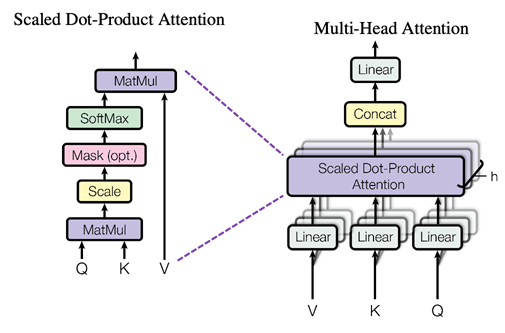

### Loại bỏ softmax khỏi MHA
Bằng cách loại bỏ hoàn toàn Softmax trong cơ chế Attention, chúng ta sẽ kiểm tra xem sự thiếu vắng của nó ảnh hưởng như thế nào đến khả năng huấn luyện và hiệu suất của mô hình. Điều này giúp chúng ta hiểu rõ hơn về tầm quan trọng của Softmax trong việc chuẩn hóa các điểm số Attention thành các xác suất, từ đó xác định trọng số của từng phần tử đầu vào.

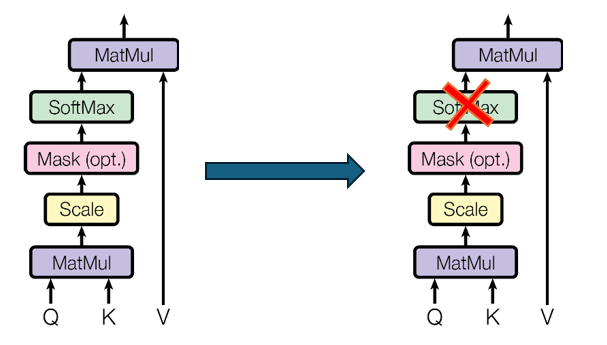

In [20]:
from tensorflow.keras.layers import MultiHeadAttention
import math


class BMultiHeadAttention(MultiHeadAttention):
    def _compute_attention(
        self, query, key, value, attention_mask=None, training=None
    ):
        # TODO: cài đặt lại hàm hàm `_compute_attention` đã được định nghĩa trước đó trong lớp `MultiHeadAttention` nhưng loại Softmax
        # các input và output sẽ tương tự hàm '_compute_attention' trước đó
        #
        # Kham khảo mã nguồn MultiHeadAttention: https://github.com/keras-team/keras/tree/v2.15.0/keras/layers/attention/multi_head_attention.py#L130-L731
        #                    Softmax with mask: https://github.com/keras-team/keras/blob/v2.15.0/keras/layers/activation/softmax.py#L49
        
        ### BEGIN SOLUTION
        query = tf.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        
        if attention_mask is not None:
            attention_mask = tf.cast(attention_mask, attention_scores.dtype)
            if len(attention_mask.shape) == 3:
                attention_mask = tf.expand_dims(attention_mask, axis=1)  # [B, 1, Q, K]
            attention_scores += (1.0 - attention_mask) * -1e9

        attention_scores_dropped = self._dropout_layer(attention_scores, training=training)

        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropped, value
        )
        ### END SOLUTION
        
        return attention_output, attention_scores

In [21]:
class BBaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

        self.mha  = None
        self.layernorm = None
        self.add = None

        self.mha = BMultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class BCrossAttention(BBaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class BGlobalSelfAttention(BBaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class BCausalSelfAttention(BBaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class BEncoderLayer(EncoderLayer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        self.self_attention = BGlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
class BEncoder(Encoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.enc_layers = [
            BEncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]

class BDecoderLayer(DecoderLayer):
    def __init__(self,
                **kwargs):
        super().__init__(**kwargs)

        self.causal_self_attention = BCausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = BCrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

class BDecoder(Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.dec_layers = [
            BDecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]


class Beta(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = BEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = BDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

beta = Beta(
          num_layers=num_layers,
          d_model=d_model,
          num_heads=num_heads,
          dff=dff,
          input_vocab_size=num_eng_tokens,
          target_vocab_size=num_vie_tokens,
          dropout_rate=dropout_rate,
          vie_word_dict=vie_word_dict, tokenizers=tokenizers)
beta.build()

beta.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(beta, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'b_global_self_attention_6' (of type BGlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_58' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_58' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - loss: 6.9788 - masked_accuracy: 0.1006
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.4887 - masked_accuracy: 0.1336
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.4153 - masked_accuracy: 0.1332
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.3195 - masked_accuracy: 0.1335
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.2909 - masked_accuracy: 0.1317
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.2489 - masked_accuracy: 0.1307
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.1931 - masked_accuracy: 0.1293
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.1586 - masked_accuracy: 0.1267
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.1158 - masked_accuracy: 0.1291
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.0813 - masked_accuracy: 0.1293
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.0526

100%|██████████| 500/500 [03:10<00:00,  2.63it/s]


Giá trị bleu score là 0.08618651024394153


In [12]:
### BEGIN PUBLIC TESTS
query_t = tf.random.uniform((1, 8, 64))
key_t = tf.random.uniform((1, 8, 64))
value_t = tf.random.uniform((1, 8, 64))

custom_mha = BMultiHeadAttention(num_heads=4, key_dim=64)
out, score = custom_mha(query=query_t, key=key_t, value=value_t, return_attention_scores=True)
attention_scores_sum = tf.reduce_sum(score, axis=-1)
assert tf.reduce_all(tf.not_equal(attention_scores_sum, 1.0)).numpy()
### END PUBLIC TESTS

In [13]:
options = {0: 'hiệu suất beta xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất beta thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất beta thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất beta thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất beta thấp hơn alpha trên 20%',
           5: 'beta gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
### BEGIN SOLUTION
your_choice = 5
### END SOLUTION
print("Theo mình thì: ", options[your_choice])

Theo mình thì:  beta gần như không học gì (hiệu suất thấp hơn 10%)


### Thay thế softmax bằng sigmoid
Thay vì sử dụng Softmax để chuẩn hóa các điểm số Attention thành các xác suất, chúng ta sẽ thử thay thế nó bằng hàm kích hoạt Sigmoid. Sigmoid sẽ biến đổi các điểm số vào thành các giá trị nằm trong khoảng (0, 1), nhưng không đảm bảo tổng các giá trị bằng 1 như Softmax. Điều này có thể ảnh hưởng đến cách mô hình phân bổ trọng số cho các phần tử đầu vào.

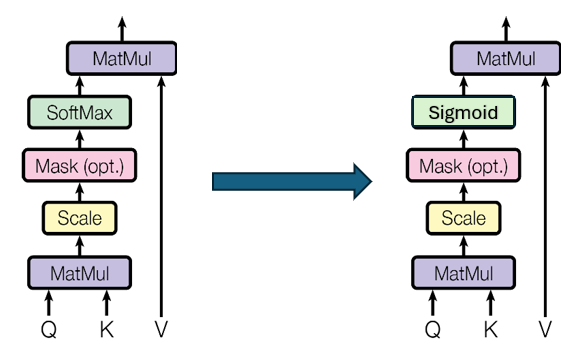

In [14]:
from tensorflow.keras.layers import MultiHeadAttention
import math

class GMultiHeadAttention(MultiHeadAttention):
    def _compute_attention(
        self, query, key, value, attention_mask, training=None
    ):
        ### BEGIN SOLUTION
        query = tf.multiply(query, 1.0 / math.sqrt(float(self._key_dim)))

        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        
        if attention_mask is not None:
            attention_mask = tf.cast(attention_mask, attention_scores.dtype)
            if len(attention_mask.shape) == 3:
                attention_mask = tf.expand_dims(attention_mask, axis=1)  # [B, 1, Q, K]
            attention_scores += (1.0 - attention_mask) * -1e9
        
        attention_scores = tf.sigmoid(attention_scores)

        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        ### END SOLUTION
        return attention_output, attention_scores

In [15]:
class GBaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()

        self.mha  = None
        self.layernorm = None
        self.add = None

        self.mha = GMultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class GCrossAttention(GBaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

class GGlobalSelfAttention(GBaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GCausalSelfAttention(GBaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GEncoderLayer(EncoderLayer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

        self.self_attention = GGlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

class GEncoder(Encoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.enc_layers = [
            GEncoderLayer(d_model=d_model,
                        num_heads=num_heads,
                        dff=dff,
                        dropout_rate=dropout_rate)
            for _ in range(num_layers)]

class GDecoderLayer(DecoderLayer):
    def __init__(self,
                **kwargs):
        super().__init__(**kwargs)

        self.causal_self_attention = GCausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = GCrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

class GDecoder(Decoder):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.dec_layers = [
            GDecoderLayer(d_model=d_model, num_heads=num_heads,
                        dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]


class Gamma(Translator):
    def __init__(self, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.0, vie_word_dict=None, tokenizers=None):
        super().__init__(num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate, vie_word_dict, tokenizers)
        self.encoder = GEncoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

        self.decoder = GDecoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

gamma=Gamma(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=num_eng_tokens,
    target_vocab_size=num_vie_tokens,
    dropout_rate=dropout_rate,
    vie_word_dict=vie_word_dict, tokenizers=tokenizers)
gamma.build()


gamma.train(encoder_train_input_data , decoder_train_input_data, decoder_target_data)
evaluate(gamma, encoder_val_input_data, val_target)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'g_global_self_attention' (of type GGlobalSelfAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'sequential_34' (of type Sequential) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'feed_forward_34' (of type FeedForward) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.wa

Epoch 1/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 7.0065 - masked_accuracy: 0.0900
Epoch 2/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.0936 - masked_accuracy: 0.2113
Epoch 3/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.3652 - masked_accuracy: 0.2904
Epoch 4/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.8015 - masked_accuracy: 0.3615
Epoch 5/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.3332 - masked_accuracy: 0.4212
Epoch 6/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.9524 - masked_accuracy: 0.4606
Epoch 7/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 2.6295 - masked_accuracy: 0.5049
Epoch 8/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.3802 - masked_accuracy: 0.5341
Epoch 9/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.0731 - masked_accuracy: 0.5736
Epoch 10/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.8396 - masked_accuracy: 0.6063
Epoch 11/12
563/563 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.6512

100%|██████████| 500/500 [05:07<00:00,  1.63it/s]


Giá trị bleu score là 0.38245238499603906


In [16]:
### BEGIN PUBLIC TESTS
custom_mha = GMultiHeadAttention(num_heads=4, key_dim=64)

query_t = tf.random.uniform((1, 8, 64))
key_t = tf.random.uniform((1, 8, 64))
value_t = tf.random.uniform((1, 8, 64))

out, score = custom_mha(query=query_t, key=key_t, value=value_t, return_attention_scores=True)

min_attn_score = tf.reduce_min(score).numpy()
max_attn_score = tf.reduce_max(score).numpy()

assert min_attn_score >=0 and max_attn_score<=1
### END PUBLIC TESTS

In [17]:
options = {0: 'hiệu suất gamma xấp xỉ alpha (không chêch lệch quá 1%)',
           1: 'hiệu suất gamma thấp hơn alpha k% (1<k<5)',
           2: 'hiệu suất gamma thấp hơn alpha k% (5<=k<10)',
           3: 'hiệu suất gamma thấp hơn alpha k% (10<=k<20)',
           4: 'hiệu suất gamma thấp hơn alpha trên 20%',
           5: 'gamma gần như không học gì (hiệu suất thấp hơn 10%)'}
your_choice = None
### BEGIN SOLUTION
your_choice = 0
### END SOLUTION
print("Theo mình thì: ", options[your_choice])

Theo mình thì:  hiệu suất gamma xấp xỉ alpha (không chêch lệch quá 1%)
